# Test models with geodata clustered in k-means

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import uuid

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

## Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [4]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer=opt)
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])
    _, k_area = series_split_sequences(test, test['k_area'], n_steps_in, n_steps_out)

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, train_true = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    _, k_area_train = series_split_sequences(train, train['k_area'], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, train_true)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_true, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test[[target_feature]])
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train[[target_feature]])
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_true': train_true,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1],
               'k_area': k_area,
               'k_area_train': k_area_train
               }

    return results

def plot_lstm_1_step(pred, true, colors:list, target_feature:str, operator:str, feature_comb:str, test_train:str):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(pred, label='Predicted', color=colors[0], zorder=2)
    true = plt.plot(true, label='True', color=colors[2], zorder=1)
    plt.xlabel('Index / Timestamp')
    plt.ylabel(target_feature)
    plt.xlim((0, 200))
    plt.title(f'Prediction on {test_train} data\n{operator}\nCombination of training features: {feature_comb}')
    plt.legend(handles=[pred[0], true[0]])
    plt.show()

    return fig

'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_in:int, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 16), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_in} steps in, {n_steps_out} steps out\n{operator}', fontsize=18, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    fig.subplots_adjust(wspace=0.5, hspace=10)

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

## Random Forest functions

In [5]:
def rf(X_train, X_test, mode_train, mode_test, campaigns:list, test_campaigns:list, features:list, n_steps_in:int, n_steps_out:int, n_estimators=100, max_depth=None, min_samples_leaf=1, preds=[], train_preds__=[]):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(preds) == 0 and len(train_preds__) == 0:
        preds_pred = None
        train_preds_pred = None
        if len(test_campaigns) == 1:
            y_pred = rf.predict(X_test[features])

            accuracy = accuracy_score(mode_test['Mode'], y_pred)
            precision = precision_score(mode_test['Mode'], y_pred)
            recall = recall_score(mode_test['Mode'], y_pred)

            y_true = mode_test['Mode']

            train_pred = rf.predict(X_train[features])

            train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
            train_precision = precision_score(mode_train['Mode'], train_pred)
            train_recall = recall_score(mode_train['Mode'], train_pred)

            train_true = mode_train['Mode']
        else:
            X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
            X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
            
            y_pred = rf.predict(X_test_test[features])

            y_pred_total = rf.predict(X_test[features])
            accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
            precision = precision_score(mode_test['Mode'], y_pred_total)
            recall = recall_score(mode_test['Mode'], y_pred_total)

            y_true = X_test_mode['Mode']

            X_train_test = X_train[X_train['campaign'] == campaigns[0]]
            X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

            train_pred = rf.predict(X_train_test[features])

            train_pred_total = rf.predict(X_train[features])
            train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
            train_precision = precision_score(mode_train['Mode'], train_pred_total)
            train_recall = recall_score(mode_train['Mode'], train_pred_total)

            train_true = X_train_mode['Mode']

        pred_accuracy, pred_recall, pred_precision = 0, 0, 0
        train_pred_accuracy, train_pred_recall, train_pred_precision = 0, 0, 0

    else:
        _, y_true = series_split_sequences(X_test, mode_test['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, test_seq = series_split_sequences(X_test, X_test[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_true = series_split_sequences(X_train, mode_train['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_seq = series_split_sequences(X_train, X_train[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        y_pred = []
        preds_pred = []
        train_preds = []
        train_preds_pred = []

        for i in range(len(test_seq)):
            pred = rf.predict(test_seq[i])
            y_pred.append(pred)
        
        for i in range(len(preds)):
            row = preds.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            preds_pred.append(pred)

        for i in range(len(train_seq)):
            pred = rf.predict(train_seq[i])
            train_preds.append(pred)
        
        for i in range(len(train_preds__)):
            row = train_preds__.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            train_preds_pred.append(pred)
        
        accuracy, recall, precision = metrics(y_true, y_pred)
        train_accuracy, train_recall, train_precision = metrics(train_true, train_preds)
        pred_accuracy, pred_recall, pred_precision = metrics(y_true, preds_pred)
        train_pred_accuracy, train_pred_recall, train_pred_precision = metrics(train_true, train_preds_pred)
    
    acc, train_acc = [], []

    if n_steps_out > 1:
        for i in range(n_steps_out):
            acc.append(accuracy_score(np.array(y_true)[:, i], np.array(y_pred)[:, i]))
            train_acc.append(accuracy_score(np.array(train_true)[:, i], np.array(train_preds)[:, i]))

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'pred_pred': preds_pred,
               'train_true': train_true,
               'train_pred': train_preds,
               'train_pred_pred':  train_preds_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_pred': round(pred_accuracy, 3),
               'Precision_pred': round(pred_recall, 3),
               'Recall_pred': round(pred_precision, 3),
               'Accuracy_train_pred': round(train_pred_accuracy, 3),
               'Recall_train_pred': round(train_pred_recall, 3),
               'Precision_train_pred': round(train_pred_precision, 3),
               'model': rf,
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }
    return results

def plot_mode(pred, true, preds, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(preds, color=colors[0], label='Predicted on predicted values', zorder=1)
    plt.plot(np.array(pred) + 2, color=colors[1], label='Predicted on true values', zorder=2)
    plt.plot(np.array(true) + 4, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 6))
    plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.show()
    return fig

In [6]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [7]:
overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
           'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
           'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

df = read_dataset(dataset, campaigns=overlap[0:3])

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap[3]])
df = pd.concat([route_to_add[5350::], df])
df.reset_index(drop=True, inplace=True)

df['ID'] = [str(uuid.uuid4()) for _ in range(len(df))]
X = df.loc[:, ['ID','Latitude','Longitude']]

## K-means of geodata

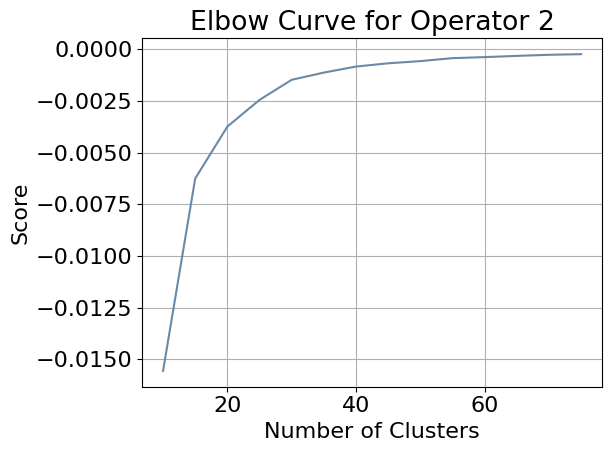

In [9]:
k_clusters = range(10, 80, 5)
kmeans = [KMeans(n_clusters=i) for i in k_clusters]

y_axis = df[['Latitude']]
X_axis = df[['Longitude']]

score = [kmeans[i].fit(y_axis).score(y_axis) for i in range(len(kmeans))]

fig = plt.figure()
plt.plot(k_clusters, score, color=rsrp_colors[1], zorder=2)
plt.grid(zorder=1)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve for Operator 2')
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/rf_loc/op2_elbow_curve.pdf')

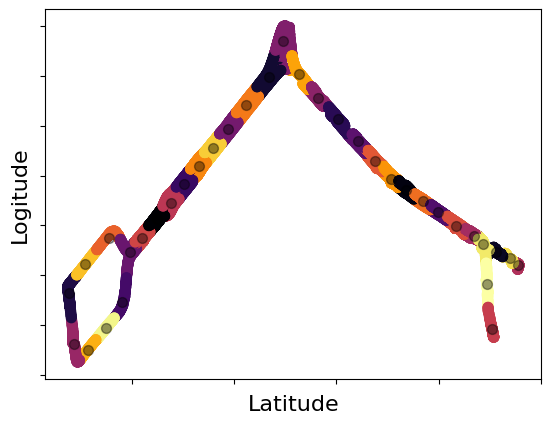

In [9]:
kmeans = KMeans(n_clusters=35, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op2_map_35_clusters_kmeans.pdf')

In [10]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,12
1,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,12
2,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,12
3,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,12
4,-107.06,4.83,-17.18,-116.8,-2.8,-15.0,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,12
...,...,...,...,...,...,...,...,...,...
10328,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,32
10329,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,32
10330,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,32
10331,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,32


In [11]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

## LSTM

### 1 step ahead

In [12]:
units = [10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [13]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [14]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00288,0.00188,1.71,1.74
1,"RSRP, SINR -> RSRP",0.00246,0.00060,0.89,0.71
2,"RSRP, RSRQ -> RSRP",0.00262,0.00106,1.23,1.17
3,"RSRP, SINR, RSRQ -> RSRP",0.00214,0.00155,1.41,1.46
4,"RSRP, SSS_RSRP -> RSRP",0.00251,0.00067,0.91,0.79
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00279,0.00064,0.87,0.69
6,SINR -> SINR,0.00166,0.00147,0.59,0.59
7,"RSRP, SINR -> SINR",0.00210,0.00494,1.40,1.72
8,"SINR, RSRQ -> SINR",0.00206,0.00184,0.69,0.75
9,"RSRP, SINR, RSRQ -> SINR",0.00184,0.00187,1.15,1.00


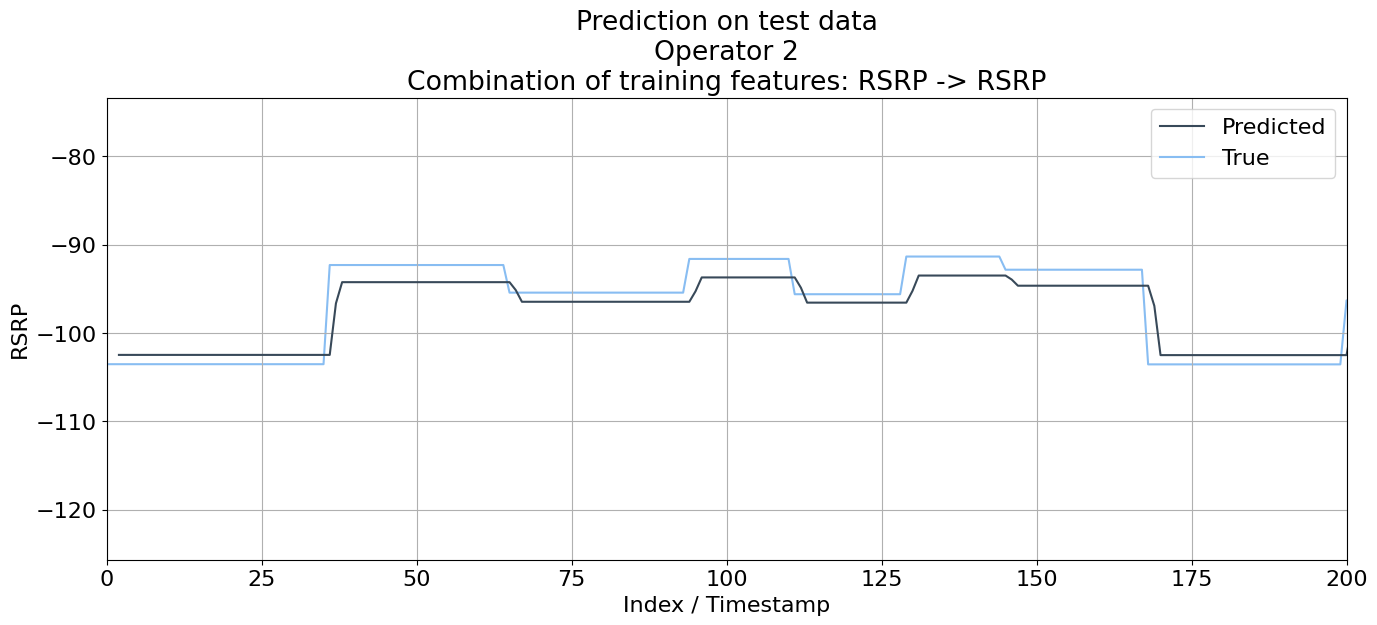

In [15]:
selected_rsrp_comb = 'RSRP -> RSRP'
rsrp_comb = lstm_results_1_step[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred_plot']
rsrp_true = rsrp_comb['y_true_plot']
rsrp_train_pred = rsrp_comb['train_pred_plot']
rsrp_train_true = rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrp_pred, true=rsrp_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='test')

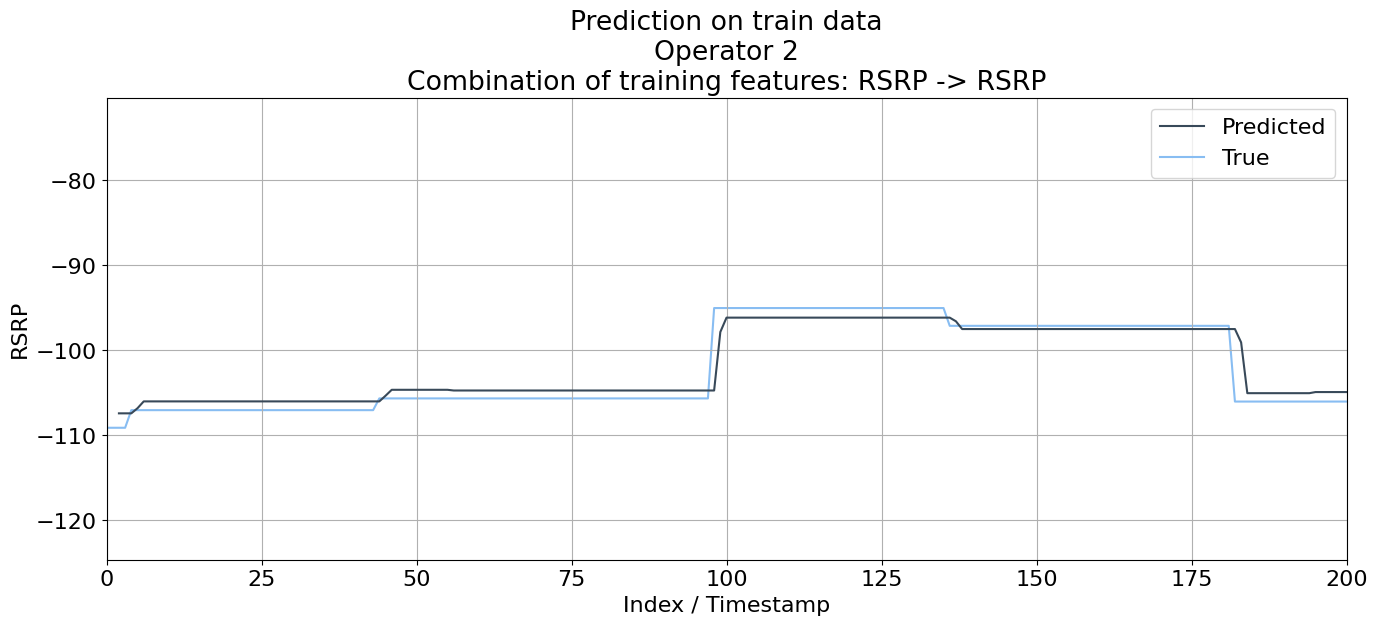

In [16]:
fig = plot_lstm_1_step(pred=rsrp_train_pred, true=rsrp_train_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='train')

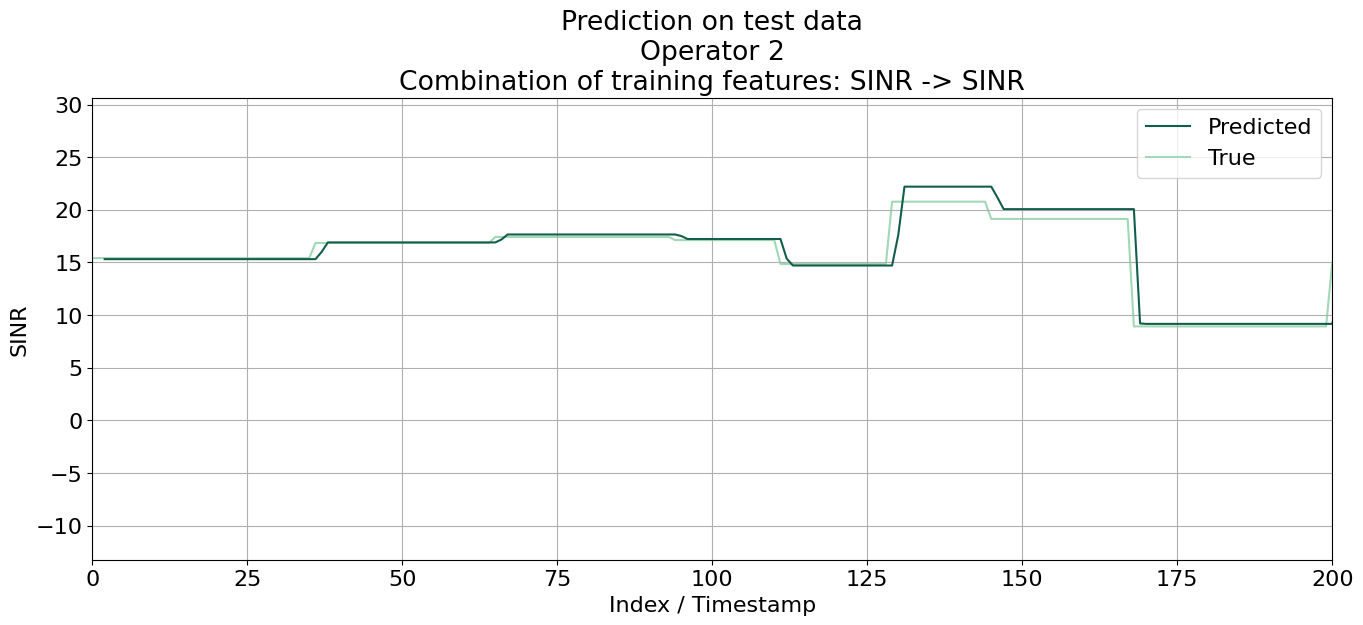

In [17]:
selected_sinr_comb = 'SINR -> SINR'
sinr_comb = lstm_results_1_step[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred_plot']
sinr_true = sinr_comb['y_true_plot']
sinr_train_pred = sinr_comb['train_pred_plot']
sinr_train_true = sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sinr_pred, true=sinr_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='test')

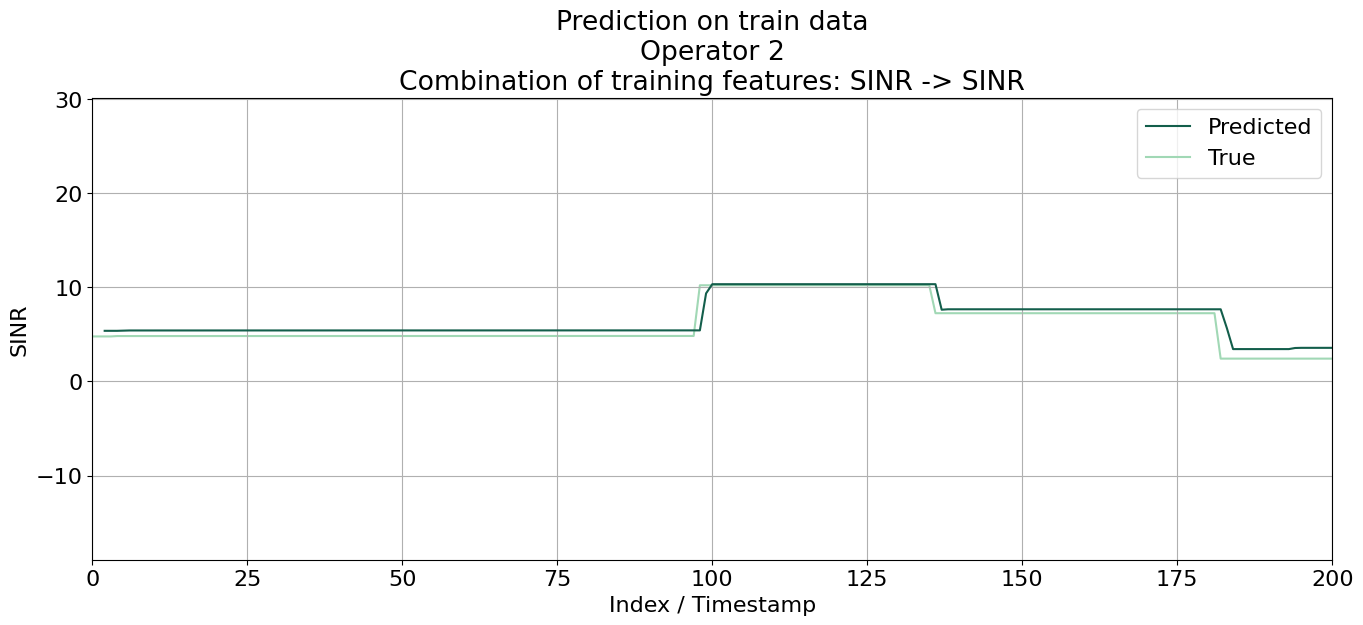

In [18]:
fig = plot_lstm_1_step(pred=sinr_train_pred, true=sinr_train_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='train')

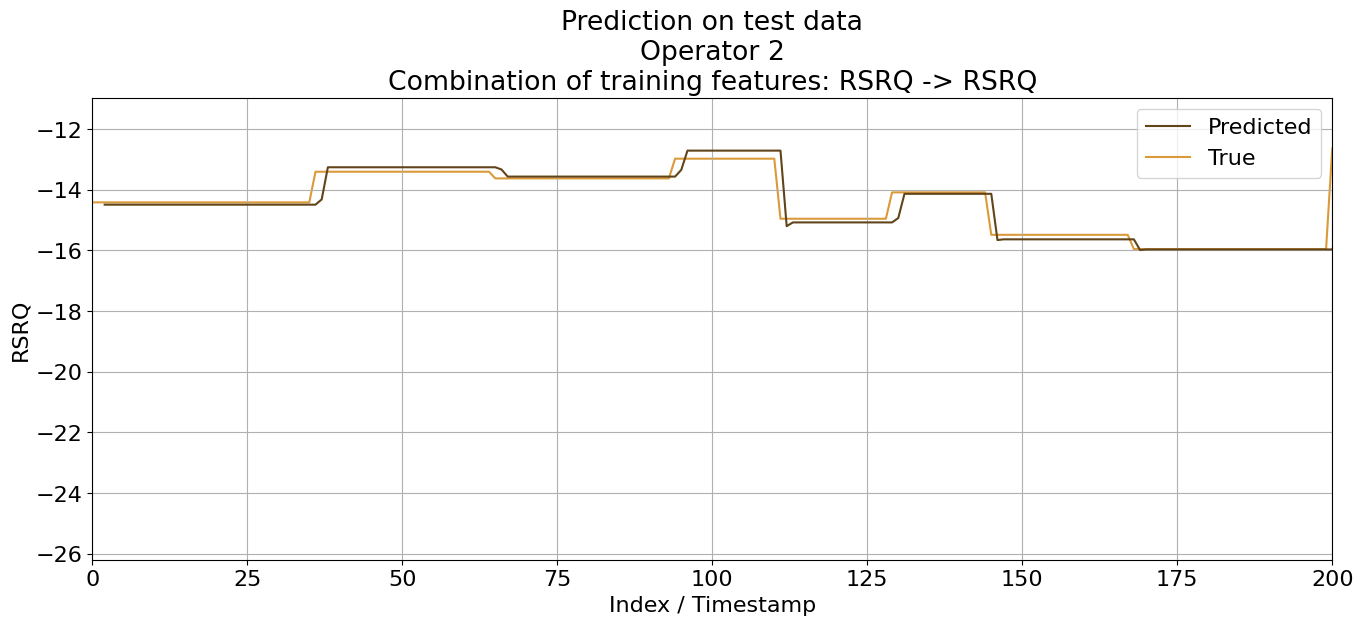

In [19]:
selected_rsrq_comb = 'RSRQ -> RSRQ'
rsrq_comb = lstm_results_1_step[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred_plot']
rsrq_true = rsrq_comb['y_true_plot']
rsrq_train_pred = rsrq_comb['train_pred_plot']
rsrq_train_true = rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrq_pred, true=rsrq_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='test')

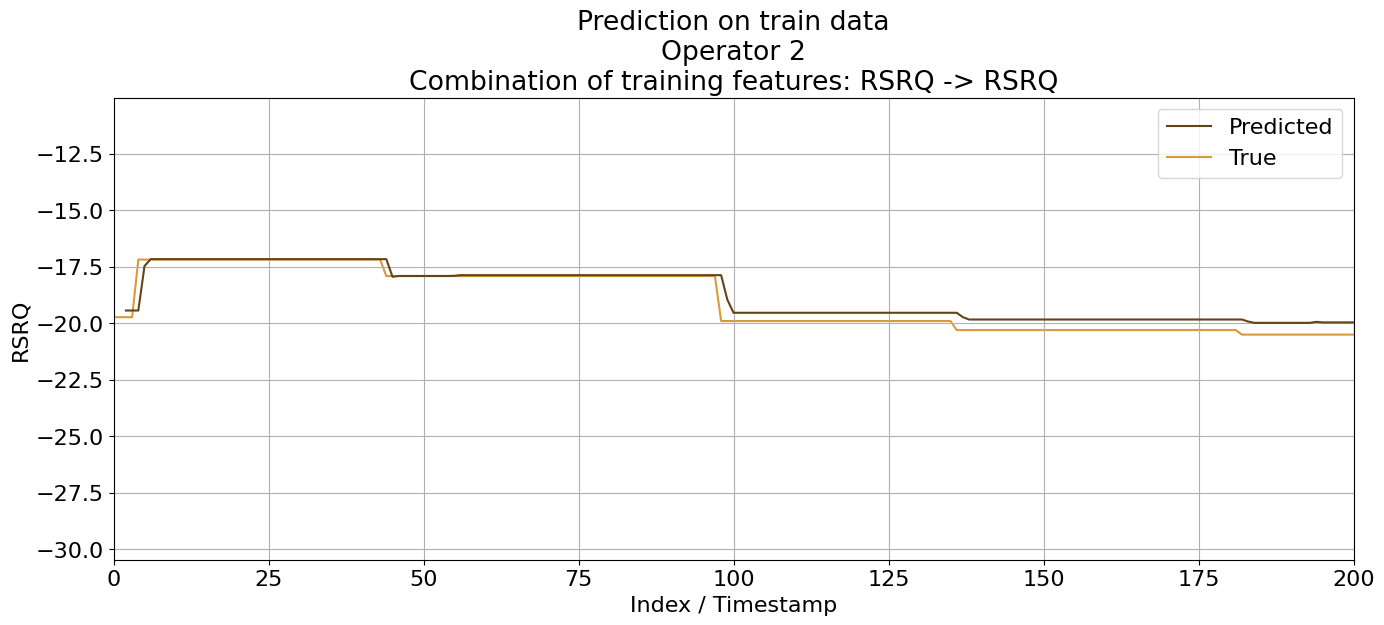

In [20]:
fig = plot_lstm_1_step(pred=rsrq_train_pred, true=rsrq_train_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='train')

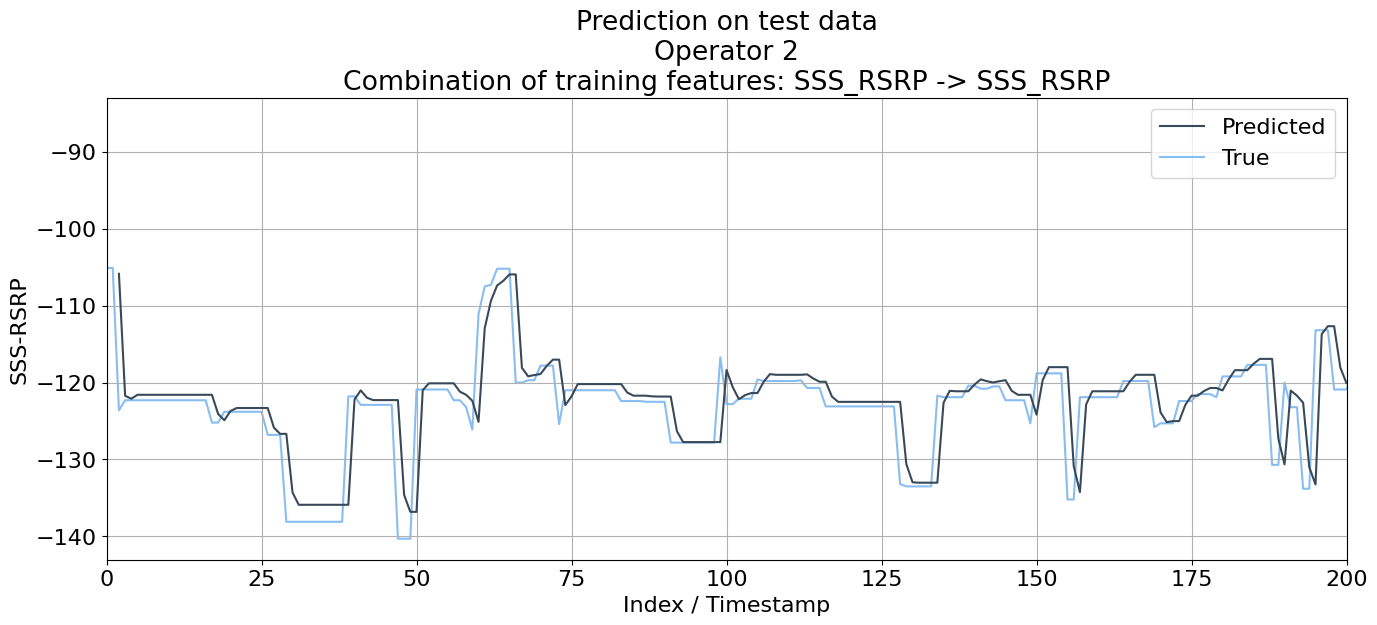

In [21]:
selected_sss_rsrp_comb = 'SSS_RSRP -> SSS_RSRP'
sss_rsrp_comb = lstm_results_1_step[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred_plot']
sss_rsrp_true = sss_rsrp_comb['y_true_plot']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred_plot']
sss_rsrp_train_true = sss_rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrp_pred, true=sss_rsrp_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='test')

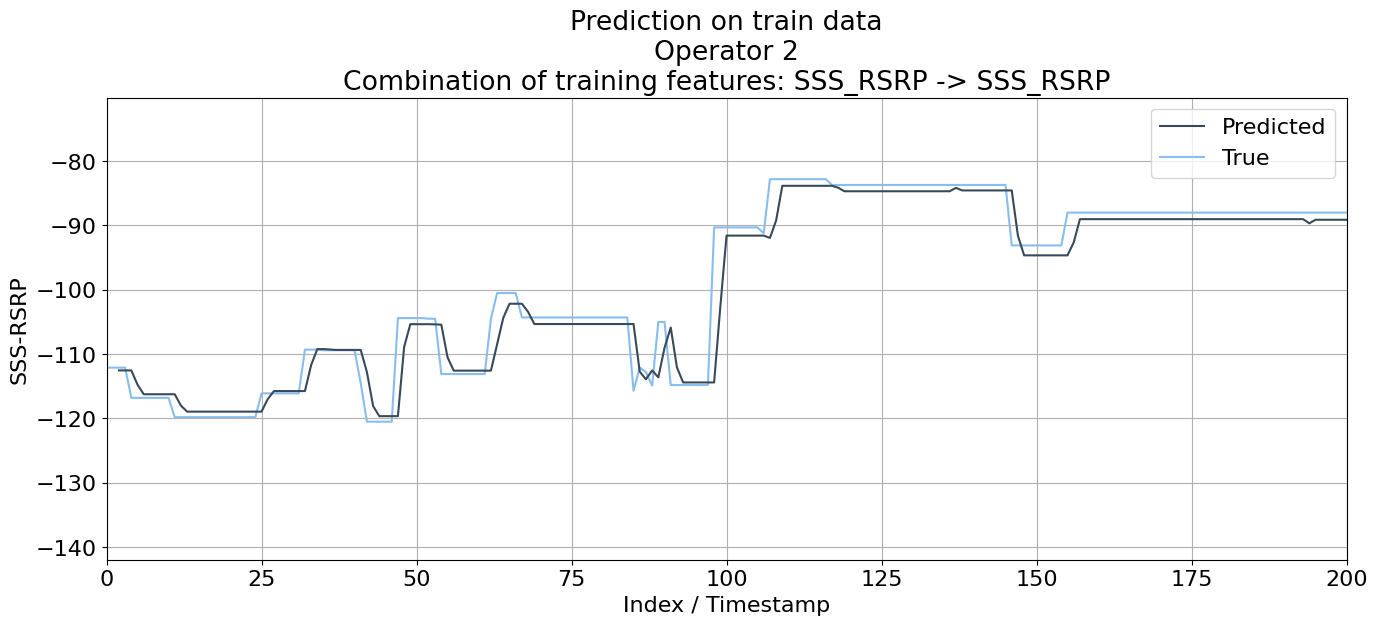

In [22]:
fig = plot_lstm_1_step(pred=sss_rsrp_train_pred, true=sss_rsrp_train_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='train')

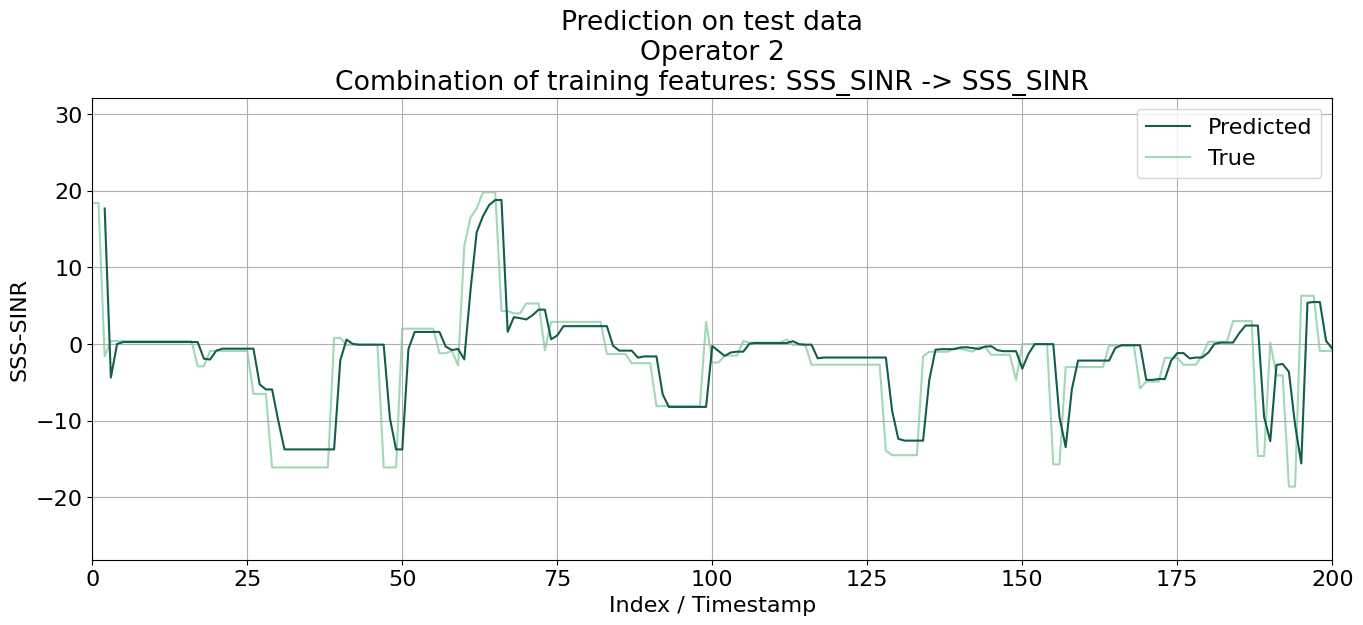

In [23]:
selected_sss_sinr_comb = 'SSS_SINR -> SSS_SINR'
sss_sinr_comb = lstm_results_1_step[selected_sss_sinr_comb]
sss_sinr_pred = sss_sinr_comb['y_pred_plot']
sss_sinr_true = sss_sinr_comb['y_true_plot']
sss_sinr_train_pred = sss_sinr_comb['train_pred_plot']
sss_sinr_train_true = sss_sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_sinr_pred, true=sss_sinr_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='test')

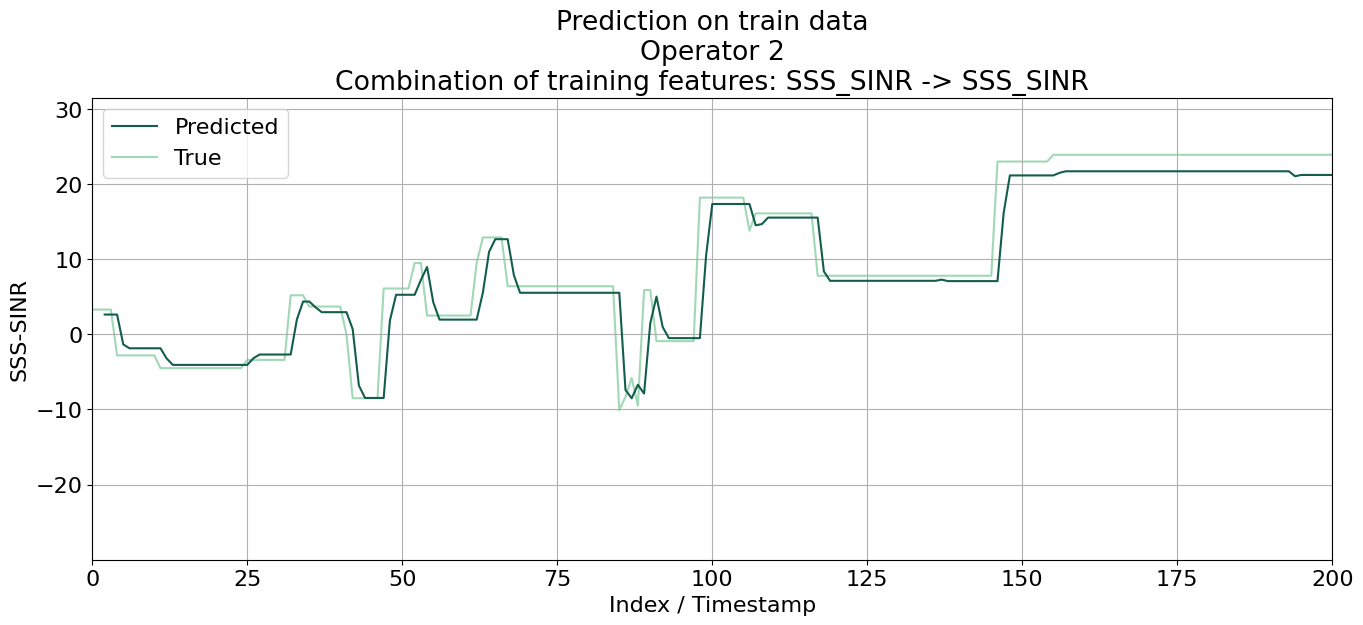

In [24]:
fig = plot_lstm_1_step(pred=sss_sinr_train_pred, true=sss_sinr_train_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='train')

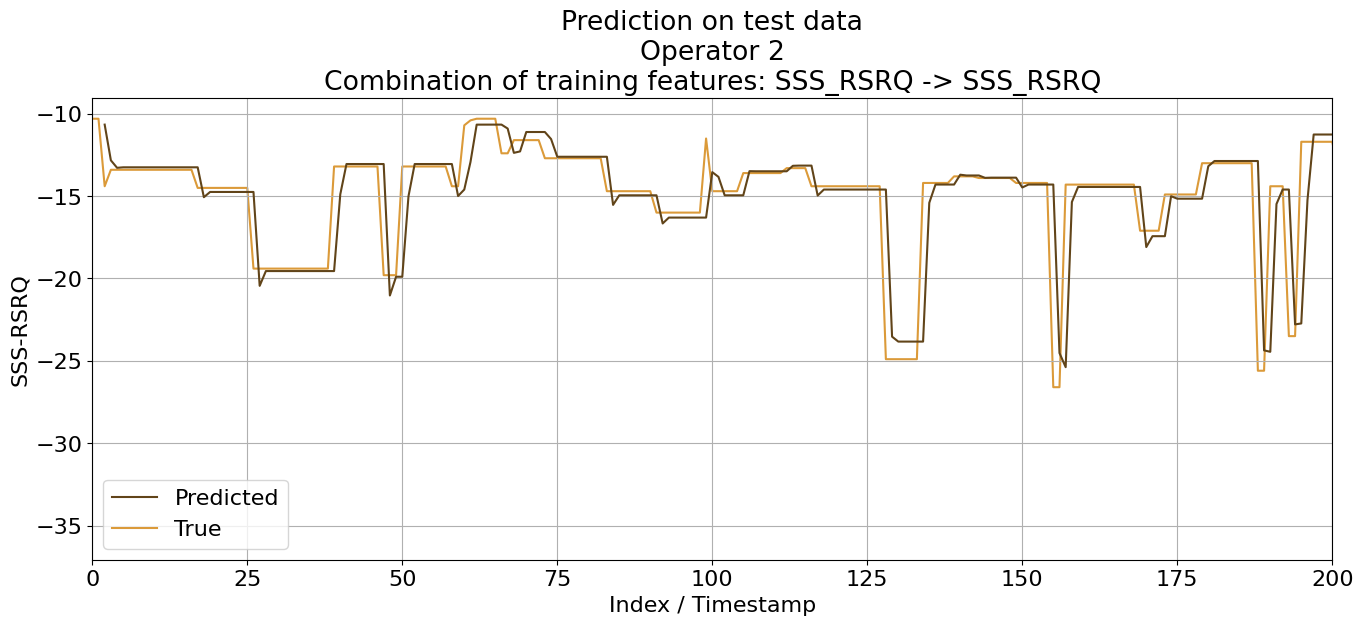

In [25]:
selected_sss_rsrq_comb = 'SSS_RSRQ -> SSS_RSRQ'
sss_rsrq_comb = lstm_results_1_step[selected_sss_rsrq_comb]
sss_rsrq_pred = sss_rsrq_comb['y_pred_plot']
sss_rsrq_true = sss_rsrq_comb['y_true_plot']
sss_rsrq_train_pred = sss_rsrq_comb['train_pred_plot']
sss_rsrq_train_true = sss_rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrq_pred, true=sss_rsrq_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

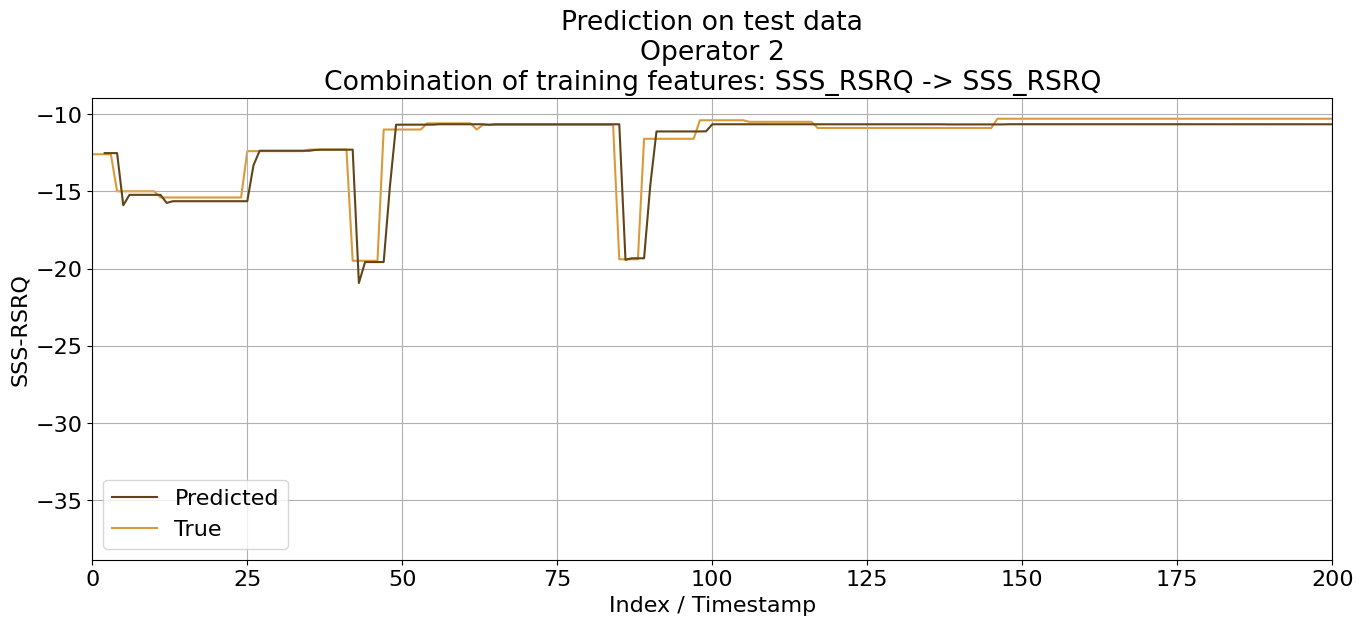

In [26]:
fig = plot_lstm_1_step(pred=sss_rsrq_train_pred, true=sss_rsrq_train_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

In [27]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [28]:
n_est, leaf = 50, 5

In [29]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]
warnings.simplefilter(action='ignore')
rf_results[f'n_est: {n_est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=n_est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 50, min_leaf: 5",0.715,0.919,0.63,0.997,0.999,0.994,0.707,0.614,0.923,0.953,0.952,0.948


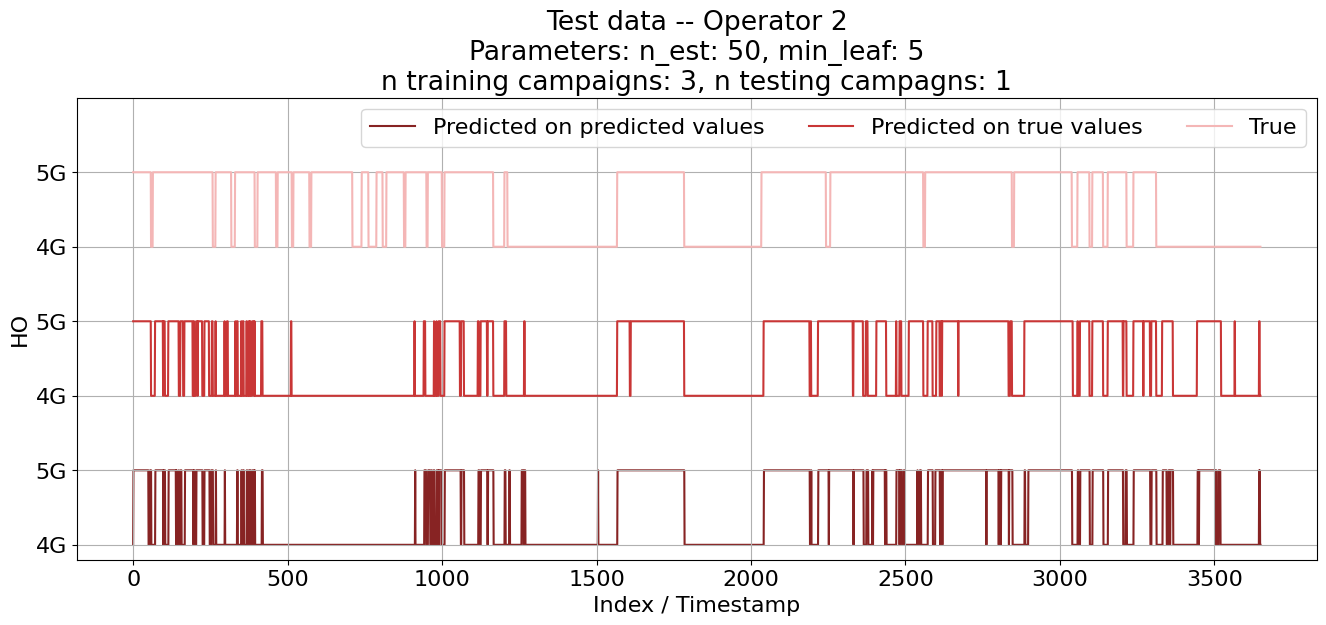

In [30]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

In [31]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [32]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 5, min_leaf: 1",0.666,0.874,0.585,0.999,0.999,0.998,0.627,0.552,0.835,0.930,0.919,0.931
1,"n_est: 5, min_leaf: 5",0.678,0.889,0.593,0.995,0.995,0.993,0.648,0.593,0.833,0.927,0.902,0.941
2,"n_est: 5, min_leaf: 10",0.673,0.886,0.587,0.992,0.992,0.991,0.639,0.580,0.830,0.934,0.908,0.950
3,"n_est: 5, min_leaf: 15",0.727,0.887,0.679,0.983,0.980,0.983,0.705,0.688,0.842,0.923,0.909,0.926
4,"n_est: 10, min_leaf: 1",0.693,0.932,0.584,0.999,0.999,0.999,0.684,0.580,0.917,0.931,0.899,0.952
5,"n_est: 10, min_leaf: 5",0.716,0.900,0.648,0.996,0.997,0.995,0.701,0.625,0.897,0.921,0.886,0.944
6,"n_est: 10, min_leaf: 10",0.727,0.918,0.650,0.992,0.988,0.994,0.703,0.651,0.873,0.927,0.902,0.940
7,"n_est: 10, min_leaf: 15",0.707,0.892,0.639,0.989,0.990,0.987,0.681,0.623,0.862,0.924,0.916,0.923
8,"n_est: 50, min_leaf: 1",0.711,0.923,0.621,0.999,0.999,0.999,0.688,0.604,0.897,0.967,0.963,0.966
9,"n_est: 50, min_leaf: 5",0.705,0.900,0.629,0.996,0.997,0.995,0.705,0.626,0.904,0.959,0.949,0.965


In [33]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.715
Mean precision: 0.913
Mean recall: 0.635


In [34]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [35]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00288,0.00188,1.71,1.74
1,"RSRP, SINR -> RSRP",0.00246,0.00060,0.89,0.71
2,"RSRP, RSRQ -> RSRP",0.00262,0.00106,1.23,1.17
3,"RSRP, SINR, RSRQ -> RSRP",0.00214,0.00155,1.41,1.46
4,"RSRP, SSS_RSRP -> RSRP",0.00251,0.00067,0.91,0.79
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00279,0.00064,0.87,0.69
6,SINR -> SINR,0.00166,0.00147,0.59,0.59
7,"RSRP, SINR -> SINR",0.00210,0.00494,1.40,1.72
8,"SINR, RSRQ -> SINR",0.00206,0.00184,0.69,0.75
9,"RSRP, SINR, RSRQ -> SINR",0.00184,0.00187,1.15,1.00


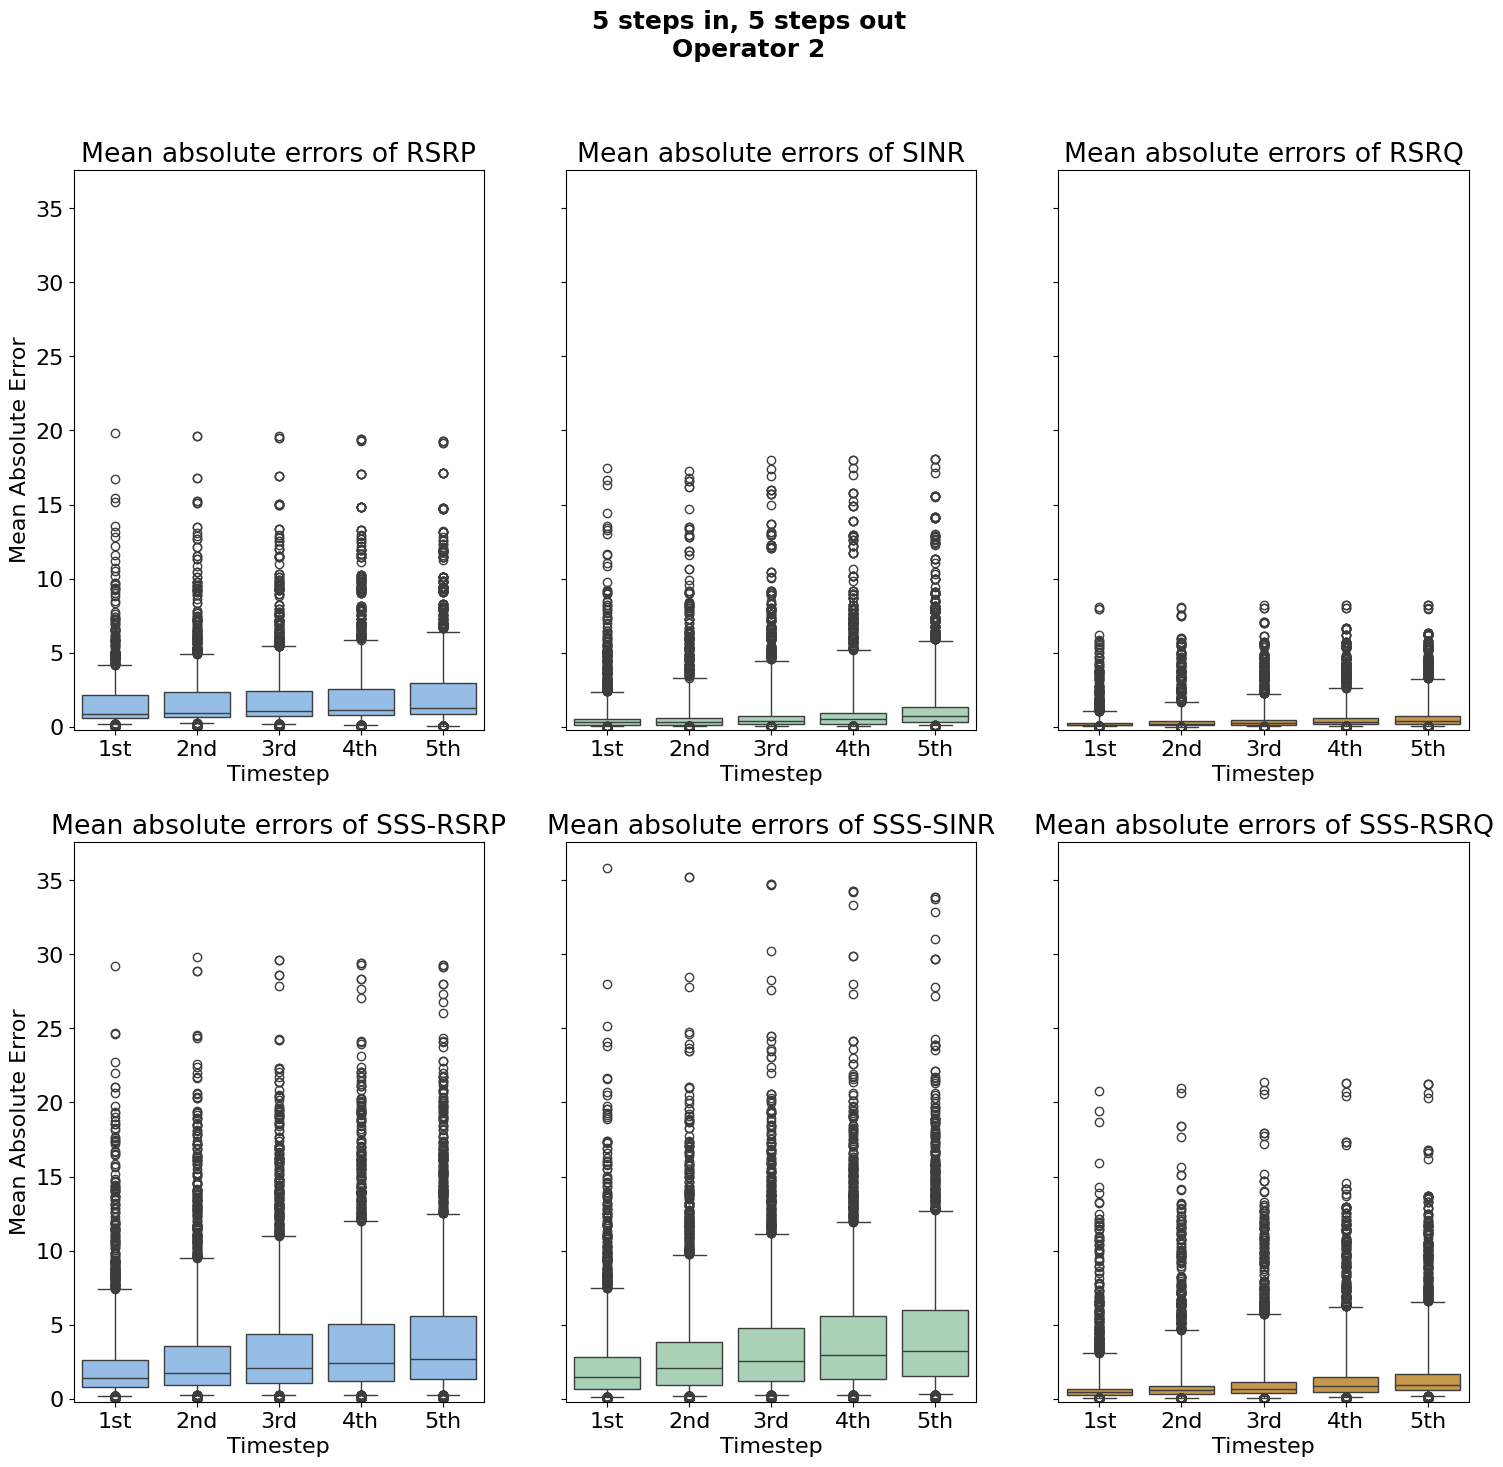

In [36]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op2_box_5_steps_mae_lstm_35_clusters.pdf')

In [37]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [38]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.698,0.893,0.623,0.999,0.999,0.999,0.680,0.608,0.875,0.866,0.830,0.879,"[0.6983255558605544, 0.6980510568213011, 0.697...","[0.9987977156597535, 0.9987977156597535, 0.998..."
1,"n_est: 5, min_leaf: 5",0.711,0.886,0.652,0.993,0.991,0.994,0.700,0.634,0.884,0.897,0.845,0.931,"[0.7112270107054626, 0.7109525116662092, 0.710...","[0.992936579501052, 0.992936579501052, 0.99293..."
2,"n_est: 5, min_leaf: 10",0.663,0.844,0.610,0.989,0.990,0.988,0.650,0.629,0.806,0.874,0.824,0.901,"[0.6634641778753775, 0.6631896788361241, 0.663...","[0.9893297264803126, 0.9893297264803126, 0.989..."
3,"n_est: 5, min_leaf: 15",0.674,0.881,0.592,0.980,0.976,0.982,0.676,0.611,0.865,0.864,0.805,0.897,"[0.6738951413670052, 0.6736206423277519, 0.673...","[0.9798617373008717, 0.9798617373008717, 0.979..."
4,"n_est: 10, min_leaf: 1",0.645,0.892,0.534,0.999,0.999,0.999,0.645,0.548,0.876,0.889,0.827,0.930,"[0.6453472412846555, 0.6453472412846555, 0.645...","[0.9990982867448152, 0.9990982867448152, 0.999..."
5,"n_est: 10, min_leaf: 5",0.699,0.889,0.628,0.996,0.996,0.995,0.703,0.627,0.898,0.897,0.849,0.927,"[0.6988745539390612, 0.6988745539390612, 0.698...","[0.9959422903516681, 0.9959422903516681, 0.995..."
6,"n_est: 10, min_leaf: 10",0.699,0.872,0.645,0.993,0.992,0.993,0.673,0.604,0.868,0.896,0.851,0.922,"[0.6991490529783145, 0.6988745539390612, 0.698...","[0.992936579501052, 0.992936579501052, 0.99293..."
7,"n_est: 10, min_leaf: 15",0.713,0.908,0.635,0.990,0.987,0.992,0.688,0.619,0.879,0.896,0.858,0.918,"[0.7128740049409827, 0.7125995059017294, 0.712...","[0.9902314397354974, 0.9902314397354974, 0.990..."
8,"n_est: 50, min_leaf: 1",0.715,0.920,0.628,0.999,0.999,0.999,0.696,0.615,0.899,0.915,0.876,0.939,"[0.7147954982157563, 0.7147954982157563, 0.714...","[0.9990982867448152, 0.9990982867448152, 0.999..."
9,"n_est: 50, min_leaf: 5",0.730,0.919,0.654,0.998,0.999,0.997,0.695,0.617,0.895,0.913,0.880,0.933,"[0.7301674444139445, 0.7298929453746912, 0.729...","[0.9977457168620378, 0.9977457168620378, 0.997..."


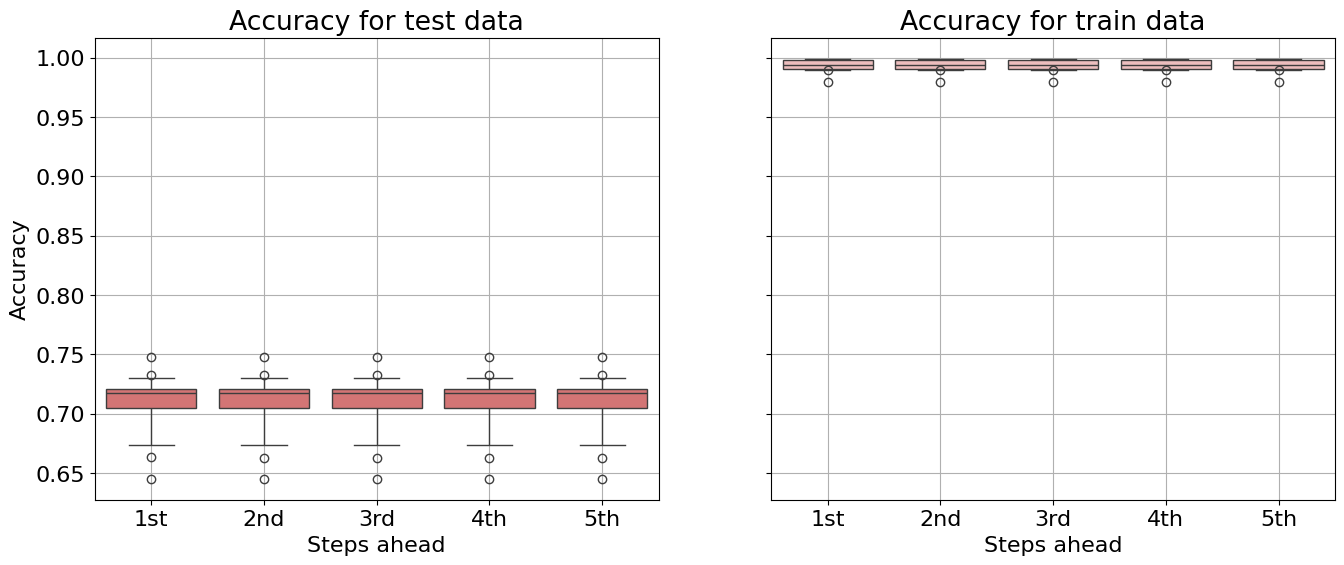

In [39]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/rf_loc/op2_boxplot_5_steps_35_clusters.pdf')

## 20 clusters

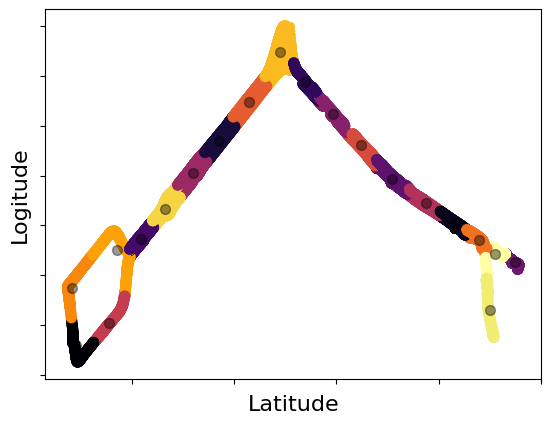

In [40]:
kmeans = KMeans(n_clusters=20, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op2_map_20_clusters_kmeans.pdf')

In [41]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,16
1,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,16
2,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,16
3,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,16
4,-107.06,4.83,-17.18,-116.8,-2.8,-15.0,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,16
...,...,...,...,...,...,...,...,...,...
10328,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,13
10329,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,13
10330,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,13
10331,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,13


In [42]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

### LSTM

#### 1 step ahead

In [43]:
units = [5, 10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [44]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [45]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00684,0.00223,2.70,2.17
1,"RSRP, SINR -> RSRP",0.00251,0.00228,1.68,1.80
2,"RSRP, RSRQ -> RSRP",0.00282,0.00221,2.35,2.10
3,"RSRP, SINR, RSRQ -> RSRP",0.00255,0.00687,3.37,3.63
4,"RSRP, SSS_RSRP -> RSRP",0.00344,0.00138,1.87,1.66
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00308,0.00179,2.08,1.75
6,SINR -> SINR,0.00273,0.00776,1.73,1.58
7,"RSRP, SINR -> SINR",0.00259,0.00693,0.82,0.83
8,"SINR, RSRQ -> SINR",0.00214,0.00309,2.03,1.64
9,"RSRP, SINR, RSRQ -> SINR",0.00302,0.00877,2.40,2.13


In [46]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

### Random Forest

In [47]:
n_est, leaf = 50, 5

In [48]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]
warnings.simplefilter(action='ignore')
rf_results[f'n_est: {n_est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=n_est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 50, min_leaf: 5",0.702,0.931,0.6,0.997,0.998,0.995,0.737,0.657,0.93,0.885,0.802,0.947,[],[]


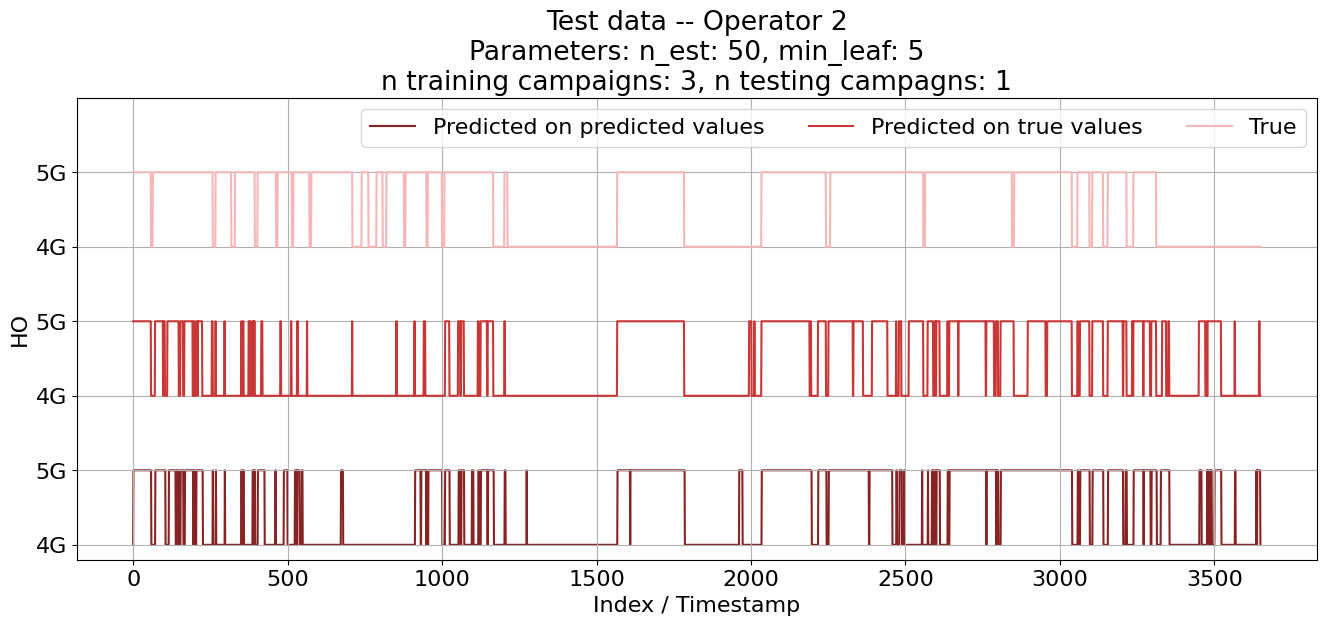

In [49]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

In [50]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [51]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.753,0.890,0.720,0.999,0.999,0.999,0.763,0.788,0.847,0.886,0.834,0.916,[],[]
1,"n_est: 5, min_leaf: 5",0.775,0.895,0.752,0.997,0.997,0.995,0.711,0.639,0.900,0.864,0.820,0.883,[],[]
2,"n_est: 5, min_leaf: 10",0.651,0.806,0.631,0.993,0.992,0.992,0.682,0.676,0.817,0.860,0.815,0.879,[],[]
3,"n_est: 5, min_leaf: 15",0.684,0.882,0.609,0.985,0.985,0.984,0.653,0.637,0.804,0.825,0.781,0.838,[],[]
4,"n_est: 10, min_leaf: 1",0.715,0.898,0.648,0.999,0.999,0.998,0.768,0.755,0.882,0.866,0.766,0.939,[],[]
5,"n_est: 10, min_leaf: 5",0.703,0.931,0.601,0.996,0.997,0.995,0.752,0.673,0.939,0.873,0.791,0.929,[],[]
6,"n_est: 10, min_leaf: 10",0.696,0.920,0.598,0.992,0.993,0.990,0.714,0.655,0.888,0.871,0.775,0.943,[],[]
7,"n_est: 10, min_leaf: 15",0.688,0.898,0.603,0.988,0.988,0.985,0.676,0.561,0.925,0.869,0.777,0.934,[],[]
8,"n_est: 50, min_leaf: 1",0.728,0.953,0.624,0.999,0.999,0.999,0.727,0.665,0.901,0.892,0.816,0.947,[],[]
9,"n_est: 50, min_leaf: 5",0.712,0.924,0.621,0.997,0.999,0.995,0.715,0.633,0.916,0.895,0.823,0.948,[],[]


In [52]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.713
Mean precision: 0.920
Mean recall: 0.627


#### 5 steps ahead

In [53]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [54]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00684,0.00223,2.70,2.17
1,"RSRP, SINR -> RSRP",0.00251,0.00228,1.68,1.80
2,"RSRP, RSRQ -> RSRP",0.00282,0.00221,2.35,2.10
3,"RSRP, SINR, RSRQ -> RSRP",0.00255,0.00687,3.37,3.63
4,"RSRP, SSS_RSRP -> RSRP",0.00344,0.00138,1.87,1.66
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00308,0.00179,2.08,1.75
6,SINR -> SINR,0.00273,0.00776,1.73,1.58
7,"RSRP, SINR -> SINR",0.00259,0.00693,0.82,0.83
8,"SINR, RSRQ -> SINR",0.00214,0.00309,2.03,1.64
9,"RSRP, SINR, RSRQ -> SINR",0.00302,0.00877,2.40,2.13


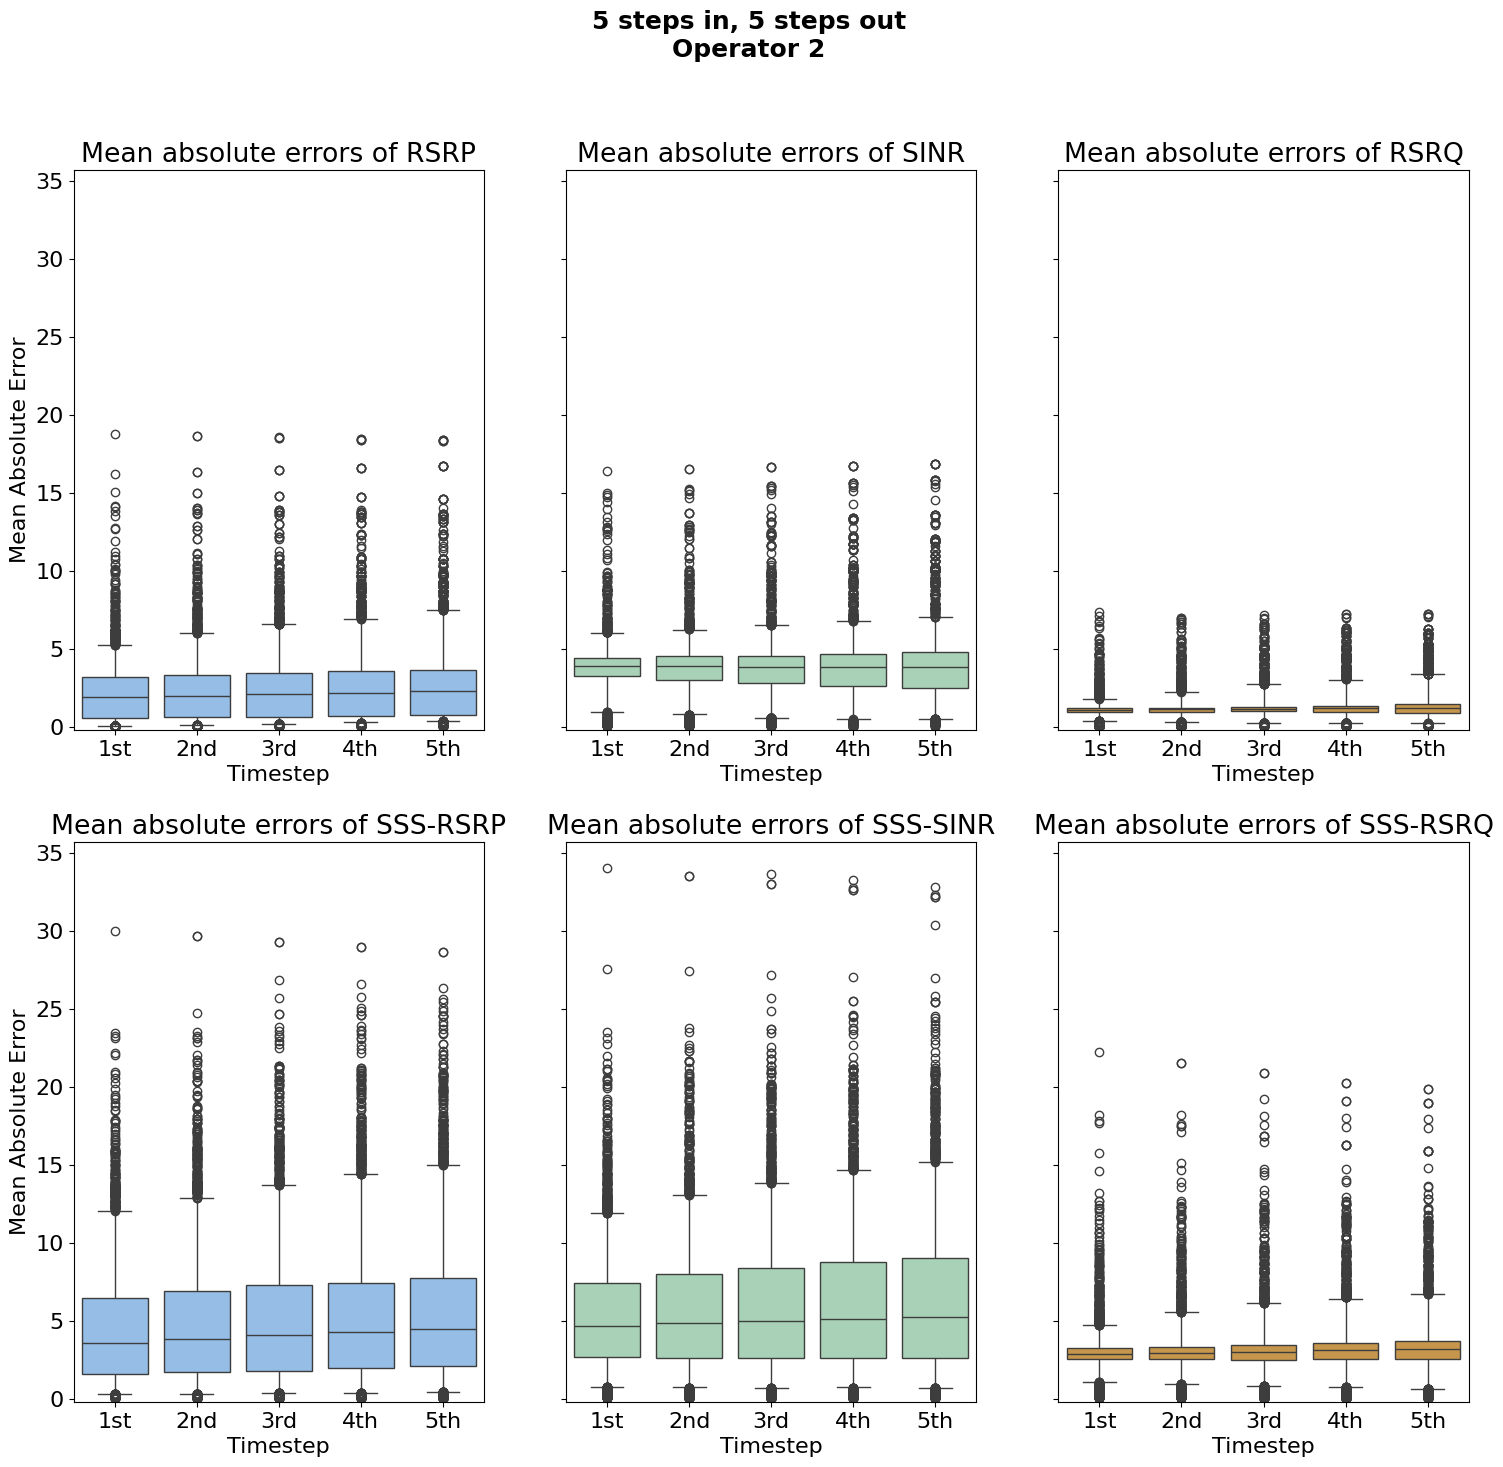

In [55]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op2_box_5_steps_mae_lstm_20_clusters.pdf')

In [56]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [57]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.707,0.891,0.641,0.999,1.000,0.998,0.748,0.827,0.803,0.791,0.855,0.742,"[0.7073840241559155, 0.7073840241559155, 0.707...","[0.9987977156597535, 0.9987977156597535, 0.998..."
1,"n_est: 5, min_leaf: 5",0.670,0.866,0.600,0.995,0.996,0.993,0.741,0.756,0.842,0.843,0.866,0.813,"[0.6706011528959649, 0.6703266538567115, 0.670...","[0.9950405770964833, 0.9950405770964833, 0.995..."
2,"n_est: 5, min_leaf: 10",0.691,0.874,0.629,0.993,0.994,0.991,0.718,0.740,0.821,0.826,0.869,0.785,"[0.691188580839967, 0.6909140818007137, 0.6909...","[0.9926360084159904, 0.9926360084159904, 0.992..."
3,"n_est: 5, min_leaf: 15",0.711,0.908,0.632,0.986,0.984,0.987,0.763,0.751,0.876,0.827,0.885,0.778,"[0.7109525116662092, 0.7106780126269558, 0.710...","[0.9860234445446348, 0.9860234445446348, 0.986..."
4,"n_est: 10, min_leaf: 1",0.716,0.922,0.628,0.999,0.999,0.999,0.733,0.762,0.825,0.815,0.859,0.774,"[0.7158934943727697, 0.7156189953335164, 0.715...","[0.9990982867448152, 0.9990982867448152, 0.999..."
5,"n_est: 10, min_leaf: 5",0.681,0.914,0.578,0.996,0.998,0.993,0.789,0.824,0.855,0.825,0.866,0.785,"[0.6810321163875926, 0.6810321163875926, 0.681...","[0.996092575894199, 0.996092575894199, 0.99609..."
6,"n_est: 10, min_leaf: 10",0.750,0.862,0.745,0.992,0.993,0.990,0.762,0.847,0.807,0.828,0.887,0.779,"[0.7499313752401866, 0.7496568762009332, 0.749...","[0.9923354373309288, 0.9923354373309288, 0.992..."
7,"n_est: 10, min_leaf: 15",0.741,0.900,0.690,0.989,0.989,0.987,0.759,0.847,0.803,0.818,0.881,0.767,"[0.7414219050233324, 0.741147405984079, 0.7411...","[0.9885782987676586, 0.9885782987676586, 0.988..."
8,"n_est: 50, min_leaf: 1",0.695,0.935,0.586,0.999,0.999,0.999,0.752,0.802,0.822,0.813,0.863,0.769,"[0.6953060664287675, 0.6953060664287675, 0.695...","[0.9990982867448152, 0.9990982867448152, 0.999..."
9,"n_est: 50, min_leaf: 5",0.706,0.922,0.612,0.997,0.997,0.997,0.721,0.784,0.796,0.798,0.882,0.741,"[0.7060115289596487, 0.7060115289596487, 0.706...","[0.9971445746919146, 0.9971445746919146, 0.997..."


In [58]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.711
Mean precision: 0.920
Mean recall: 0.624


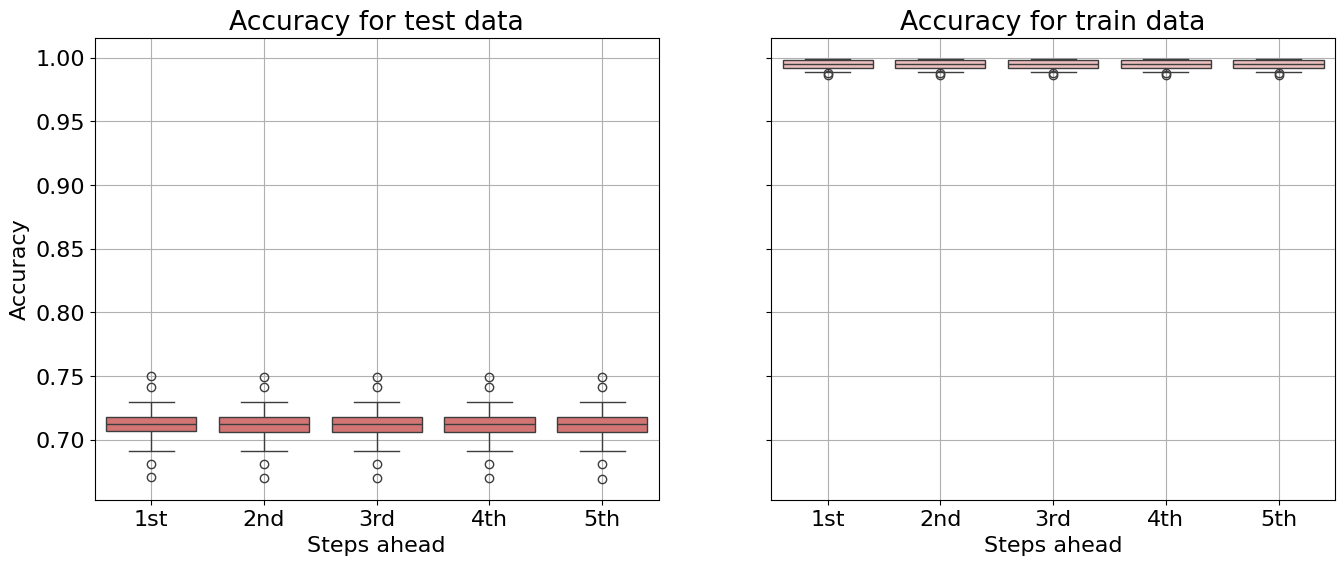

In [59]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_5_steps_20_clusters.pdf')

## 60 clusters

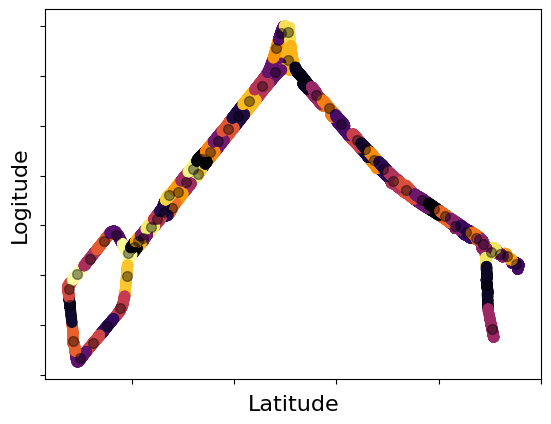

In [60]:
kmeans = KMeans(n_clusters=60, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op2_map_60_clusters_kmeans.pdf')

In [61]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,54
1,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,54
2,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,54
3,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,54
4,-107.06,4.83,-17.18,-116.8,-2.8,-15.0,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,54
...,...,...,...,...,...,...,...,...,...
10328,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,23
10329,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,23
10330,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,23
10331,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,23


In [62]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

### LSTM

#### 1 step ahead

In [63]:
units = [5, 10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [64]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00267,0.00170,1.48,1.55
1,"RSRP, SINR, RSRQ -> RSRP",0.00723,0.00246,2.92,2.40
2,"RSRP, SSS_RSRP -> RSRP",0.00340,0.00133,1.78,1.60
3,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00302,0.00211,1.75,1.82
4,SINR -> SINR,0.00230,0.00776,2.32,1.91
5,"RSRP, SINR, RSRQ -> SINR",0.00336,0.00865,1.87,1.71
6,"SINR, SSS_SINR -> SINR",0.00171,0.00256,1.77,1.41
7,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00283,0.00690,2.80,2.44
8,RSRQ -> RSRQ,0.00616,0.01090,0.71,0.87
9,"RSRP, SINR, RSRQ -> RSRQ",0.00570,0.01249,1.34,1.43


In [65]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [66]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [67]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.688,0.879,0.619,0.999,0.998,0.999,0.686,0.772,0.763,0.803,0.884,0.746,[],[]
1,"n_est: 5, min_leaf: 5",0.651,0.833,0.598,0.996,0.995,0.997,0.630,0.658,0.757,0.815,0.819,0.795,[],[]
2,"n_est: 5, min_leaf: 10",0.687,0.897,0.602,0.990,0.987,0.991,0.709,0.689,0.847,0.845,0.849,0.827,[],[]
3,"n_est: 5, min_leaf: 15",0.660,0.887,0.564,0.987,0.986,0.987,0.683,0.663,0.829,0.826,0.813,0.817,[],[]
4,"n_est: 10, min_leaf: 1",0.656,0.886,0.558,0.999,0.999,0.999,0.653,0.597,0.837,0.858,0.853,0.847,[],[]
5,"n_est: 10, min_leaf: 5",0.686,0.868,0.625,0.996,0.996,0.996,0.672,0.646,0.825,0.830,0.850,0.802,[],[]
6,"n_est: 10, min_leaf: 10",0.701,0.911,0.613,0.992,0.991,0.992,0.642,0.643,0.784,0.864,0.855,0.857,[],[]
7,"n_est: 10, min_leaf: 15",0.666,0.859,0.600,0.990,0.988,0.990,0.648,0.633,0.799,0.852,0.869,0.827,[],[]
8,"n_est: 50, min_leaf: 1",0.666,0.880,0.580,0.999,0.999,0.999,0.641,0.654,0.775,0.870,0.870,0.856,[],[]
9,"n_est: 50, min_leaf: 5",0.684,0.881,0.611,0.997,0.998,0.996,0.641,0.634,0.788,0.868,0.892,0.838,[],[]


In [68]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.679
Mean precision: 0.884
Mean recall: 0.599


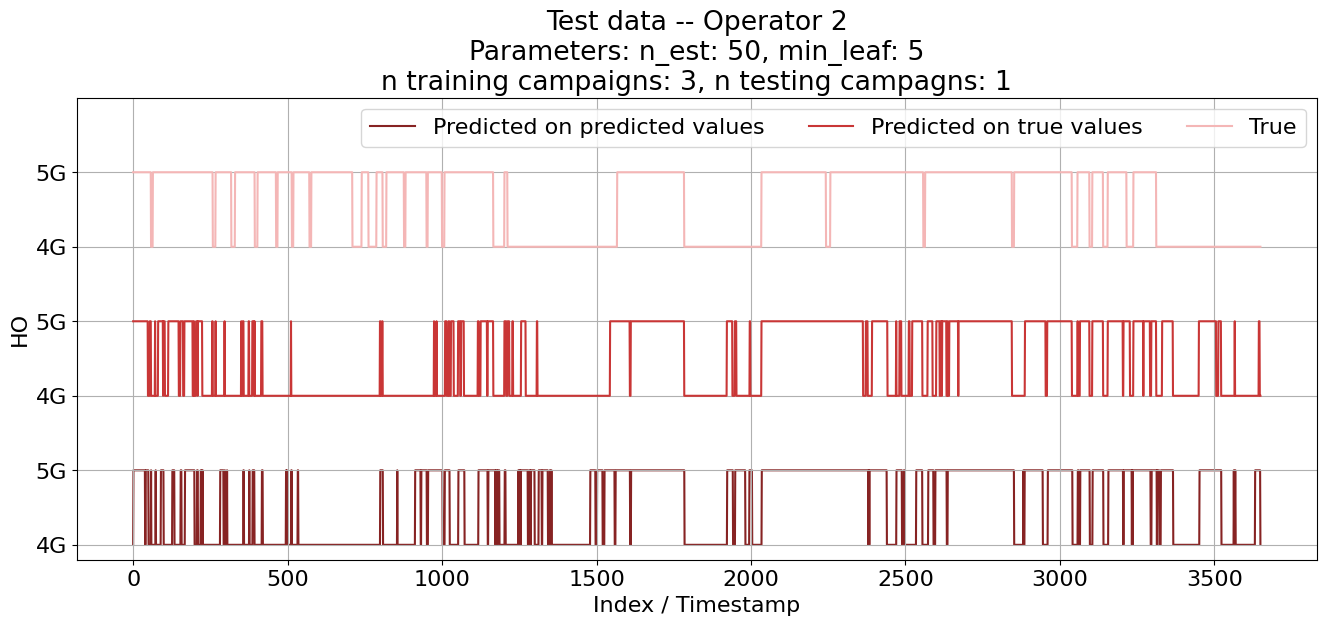

In [69]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

#### 5 steps ahead

In [70]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')
df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00267,0.00170,1.48,1.55
1,"RSRP, SINR, RSRQ -> RSRP",0.00723,0.00246,2.92,2.40
2,"RSRP, SSS_RSRP -> RSRP",0.00340,0.00133,1.78,1.60
3,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00302,0.00211,1.75,1.82
4,SINR -> SINR,0.00230,0.00776,2.32,1.91
5,"RSRP, SINR, RSRQ -> SINR",0.00336,0.00865,1.87,1.71
6,"SINR, SSS_SINR -> SINR",0.00171,0.00256,1.77,1.41
7,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00283,0.00690,2.80,2.44
8,RSRQ -> RSRQ,0.00616,0.01090,0.71,0.87
9,"RSRP, SINR, RSRQ -> RSRQ",0.00570,0.01249,1.34,1.43


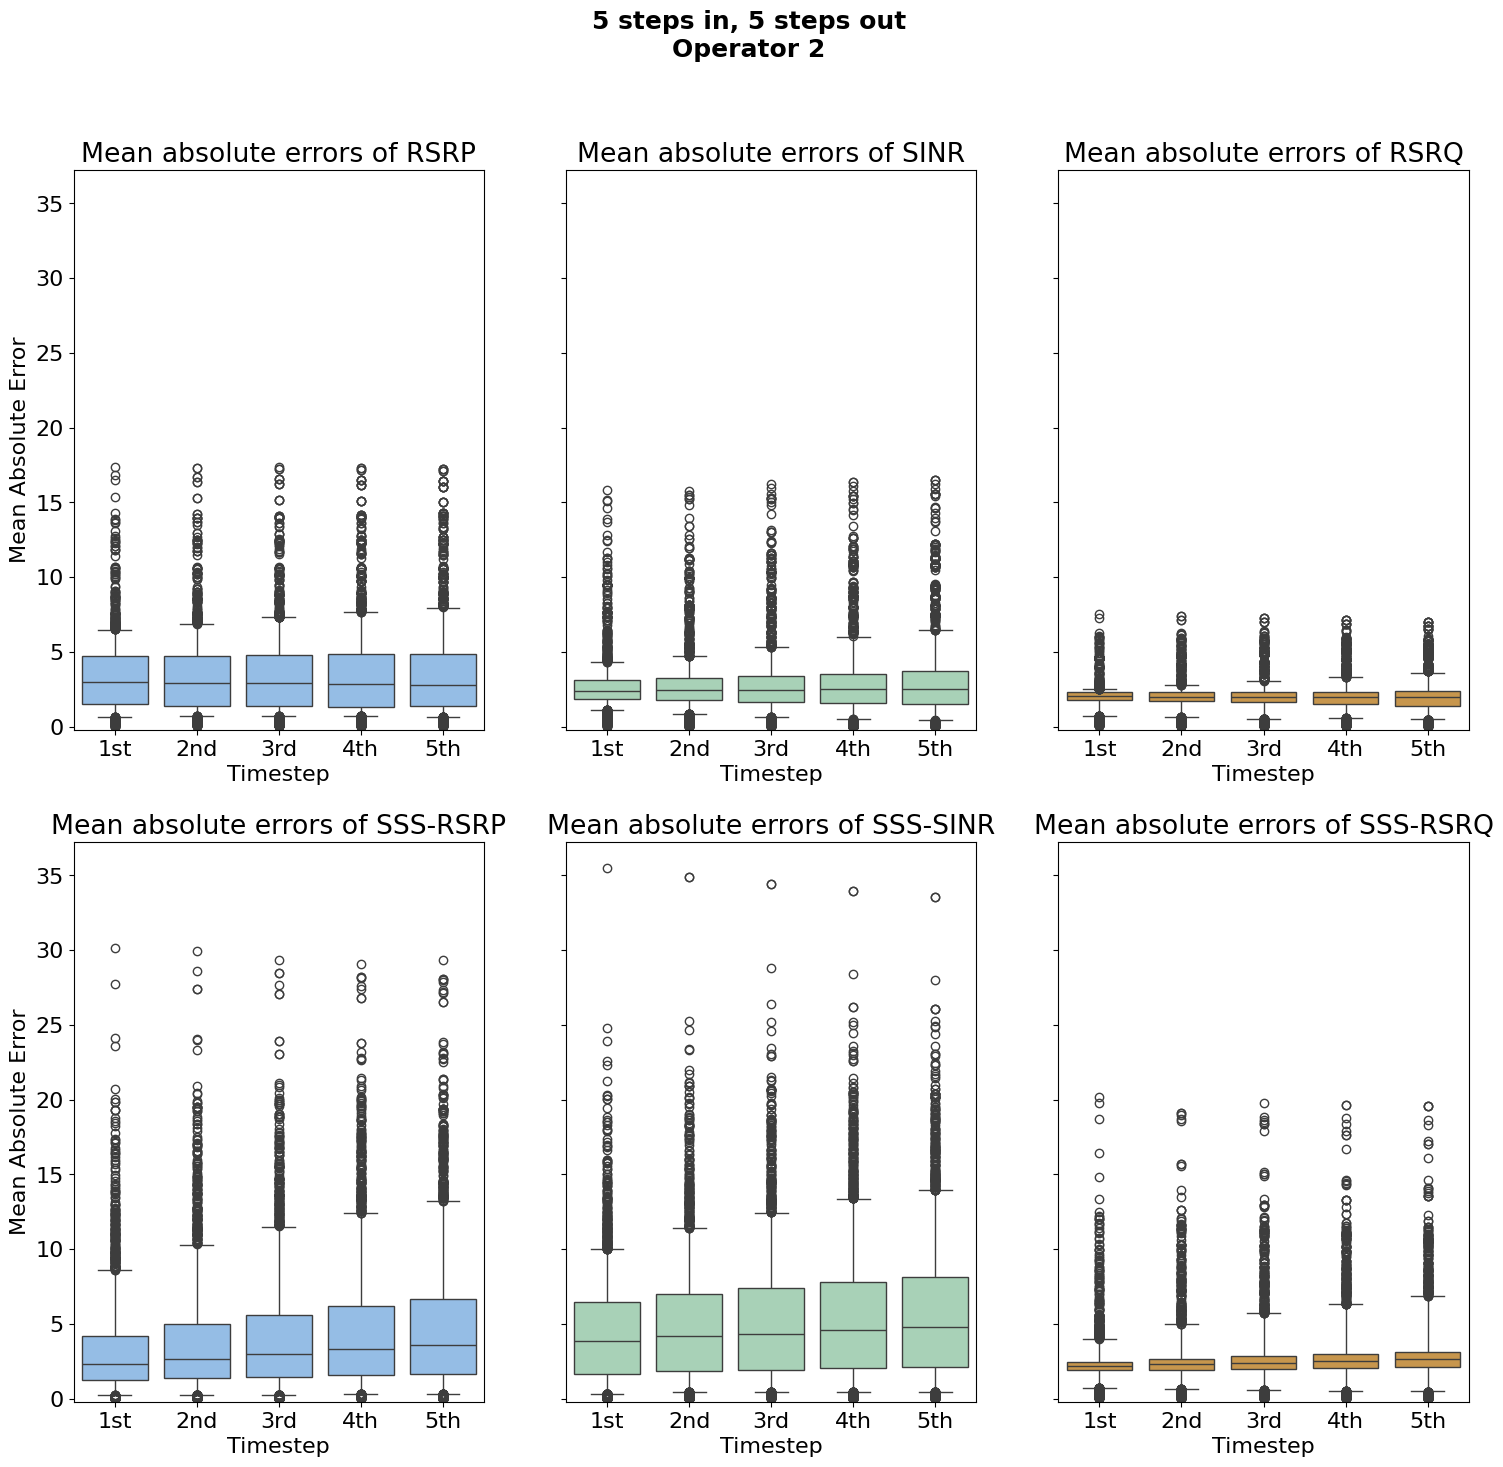

In [71]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op2_box_5_steps_mae_lstm_60_clusters.pdf')

In [72]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [73]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.679,0.854,0.628,0.999,0.999,0.999,0.626,0.662,0.749,0.773,0.858,0.717,"[0.6793851221520725, 0.6791106231128191, 0.679...","[0.9990982867448152, 0.9990982867448152, 0.999..."
1,"n_est: 5, min_leaf: 5",0.677,0.850,0.628,0.994,0.991,0.996,0.646,0.647,0.786,0.767,0.833,0.718,"[0.6769146307987922, 0.6769146307987922, 0.676...","[0.9941388638412985, 0.9941388638412985, 0.994..."
2,"n_est: 5, min_leaf: 10",0.669,0.849,0.614,0.991,0.991,0.990,0.630,0.699,0.735,0.784,0.858,0.731,"[0.6692286576996981, 0.6689541586604447, 0.668...","[0.9911331529906823, 0.9911331529906823, 0.991..."
3,"n_est: 5, min_leaf: 15",0.666,0.861,0.596,0.983,0.978,0.986,0.603,0.654,0.726,0.758,0.806,0.716,"[0.6656601701894044, 0.6656601701894044, 0.665...","[0.9828674481514879, 0.9828674481514879, 0.982..."
4,"n_est: 10, min_leaf: 1",0.673,0.886,0.586,0.999,0.999,0.999,0.646,0.641,0.791,0.798,0.843,0.758,"[0.6725226461707384, 0.6725226461707384, 0.672...","[0.9990982867448152, 0.9990982867448152, 0.999..."
5,"n_est: 10, min_leaf: 5",0.690,0.893,0.610,0.996,0.997,0.995,0.628,0.634,0.770,0.748,0.844,0.691,"[0.6898160856437002, 0.6898160856437002, 0.689...","[0.9962428614367298, 0.9962428614367298, 0.996..."
6,"n_est: 10, min_leaf: 10",0.671,0.902,0.570,0.995,0.993,0.996,0.637,0.601,0.808,0.774,0.812,0.737,"[0.6703266538567115, 0.6703266538567115, 0.670...","[0.9947400060114217, 0.9947400060114217, 0.994..."
7,"n_est: 10, min_leaf: 15",0.659,0.823,0.626,0.991,0.987,0.995,0.595,0.668,0.710,0.779,0.857,0.725,"[0.6598956903650838, 0.6596211913258304, 0.659...","[0.9911331529906823, 0.9911331529906823, 0.991..."
8,"n_est: 50, min_leaf: 1",0.682,0.885,0.602,0.999,0.999,0.999,0.645,0.672,0.769,0.796,0.886,0.736,"[0.6821301125446061, 0.6818556135053527, 0.681...","[0.9990982867448152, 0.9990982867448152, 0.999..."
9,"n_est: 50, min_leaf: 5",0.673,0.870,0.602,0.997,0.998,0.996,0.612,0.676,0.725,0.773,0.863,0.716,"[0.6730716442492451, 0.6730716442492451, 0.673...","[0.996844003606853, 0.996844003606853, 0.99684..."


In [74]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.681
Mean precision: 0.883
Mean recall: 0.604


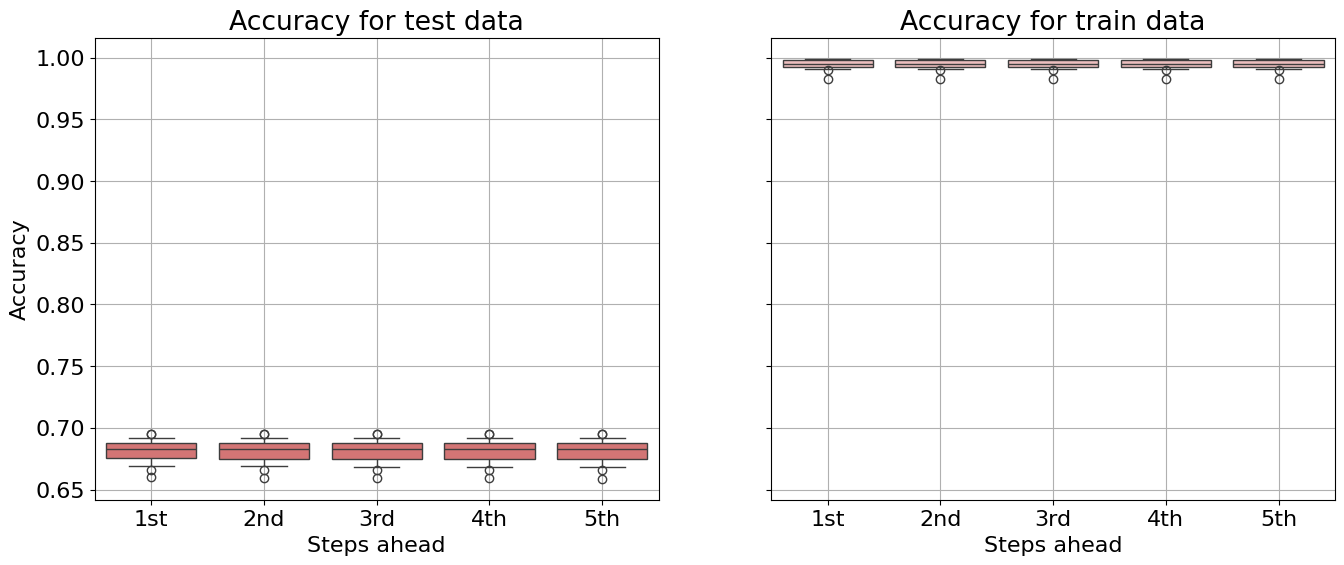

In [75]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/rf_loc/op2_boxplot_5_steps_60_clusters.pdf')